In [2]:
import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
from unittest import TestCase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set up data:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

# Initialise project:
project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_omx")
matrix.computational_view()

# Extra data specific to ODME:
index = car_graph.nodes_to_indices
dims = matrix.matrix_view.shape
count_vol_cols = ["class", "link_id", "direction", "obs_volume"]
# Still need to add mode/class name to these!!!

# Initial assignment parameters:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5
assignment.set_algorithm("msa")

In [5]:
algorithm = "reg_spiess"

# Get original flows:
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
# SQUISH EXTRA DIMENSION FOR NOW - DEAL WITH THIS PROPERLY LATER ON!!!
matrix.matrix_view = np.squeeze(matrix.matrix_view, axis=2)

# Set the observed count volumes:
flow = lambda i: assign_df.loc[assign_df["link_id"] == i, "matrix_ab"].values[0]
count_volumes = pd.DataFrame(
    data=[["car", i, 1, flow(i)] for i in assign_df["link_id"]],
    columns=count_vol_cols
)

# Store original matrix
original_demand = np.copy(matrix.matrix_view)

# Perturb original matrix:
np.random.seed(0)
perturbation = 5 # %
perturbation_matrix = np.random.uniform(1 - perturbation/100, 1 + perturbation/100, size=dims)
new_matrix = np.round(matrix.matrix_view * perturbation_matrix)

In [6]:
cumulative_factors = []

for i in range(1, 11):
    matrix.matrix_view = np.copy(new_matrix)

    # Perform ODME:
    odme = ODME(assignment,
        count_volumes,
        stop_crit=(10, 250, 1000, 50),
        alpha=i/10,
        algorithm=algorithm)
    odme.execute()
    cumulative_factors.append(odme.get_cumulative_factors())
    print(f"{i} has finished running.")

1 has finished running.
2 has finished running.
3 has finished running.
4 has finished running.
5 has finished running.
6 has finished running.
7 has finished running.
8 has finished running.
9 has finished running.
10 has finished running.


In [7]:
cumulative_stats = [data.describe() for data in cumulative_factors]

In [8]:
all_stats = pd.concat(cumulative_stats, axis=1)

In [14]:
all_stats.transpose()

,count,mean,std,min,25%,50%,75%,max
Factors,576.0,1.169061,2.292599,6.908439e-06,0.209229,0.761480,1.390376,42.441316
Factors,576.0,1.057371,1.466896,3.076863e-07,0.110613,0.693261,1.314633,17.289554
Factors,576.0,1.166273,2.556551,4.024299e-05,0.097138,0.500969,1.031250,28.925358
Factors,576.0,1.062291,1.673184,2.290483e-05,0.139328,0.633462,1.224393,20.112753
Factors,576.0,1.100054,1.287858,1.025634e-04,0.338338,0.783323,1.345443,10.321323
Factors,576.0,1.087807,1.108379,7.727085e-03,0.399115,0.933990,1.356314,11.579729
Factors,576.0,1.091555,1.227442,3.459671e-03,0.363347,0.849409,1.314653,10.160009
Factors,576.0,1.099234,1.250312,5.488714e-05,0.340358,0.842854,1.332539,12.753230
Factors,576.0,1.110855,1.851880,5.679840e-05,0.223530,0.764180,1.288505,27.091469
Factors,576.0,1.042180,1.376246,5.435358e-04,0.287134,0.703673,1.245586,20.802761


In [9]:
print(cumulative_stats[2])
print(cumulative_stats[5])
print(cumulative_stats[8])

          Factors
count  576.000000
mean     1.166273
std      2.556551
min      0.000040
25%      0.097138
50%      0.500969
75%      1.031250
max     28.925358
          Factors
count  576.000000
mean     1.087807
std      1.108379
min      0.007727
25%      0.399115
50%      0.933990
75%      1.356314
max     11.579729
          Factors
count  576.000000
mean     1.110855
std      1.851880
min      0.000057
25%      0.223530
50%      0.764180
75%      1.288505
max     27.091469


In [10]:
matrix.matrix_view = np.copy(new_matrix)

# Perform ODME:
odme = ODME(assignment,
    count_volumes,
    stop_crit=(10, 250, 50, 5),
    alpha=i/10,
    algorithm="spiess")
odme.execute()
spiess_cumulative = odme.get_cumulative_factors()

In [11]:
spiess_cumulative.describe()

,Factors
count,576.000000
mean,1.146100
std,2.122760
min,0.000617
25%,0.140346
50%,0.752702
75%,1.376337
max,31.633237


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


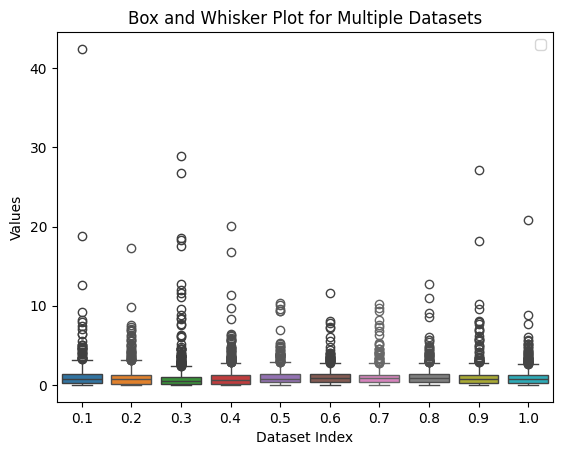

In [12]:
# Create a figure and axis
fig, ax = plt.subplots()

# Loop through each DataFrame in the list
for i, df in enumerate(cumulative_factors):
    # Plot the box and whisker plot for the current DataFrame
    sns.boxplot(x=(i+1)/10, y='Factors', data=df, ax=ax)

# Set labels and title
ax.set_xlabel('Dataset Index')
ax.set_ylabel('Values')
ax.set_title('Box and Whisker Plot for Multiple Datasets')

# Add legend
ax.legend()

# Show the plot
plt.show()